### DLTPy

In [20]:
from result_proc import copy_results, clean_output
from dltpy.preprocessing.pipeline import run_pipeline_manual
from gh_query import load_json, gen_json_file, find_current_repos
from dltpy.input_preparation.generate_df import CACHE, list_files, parse_df, gen_argument_df, filter_return_datapoints,\
    format_df, encode_types
from dltpy.input_preparation.df_to_vec import process_datapoints, ParameterDatapoint, ReturnDatapoint
from dltpy.input_preparation.embedder import Embedder
from dltpy import config
from gensim.models import Word2Vec
from importlib import reload
import os
import pickle
import re
import pandas as pd
import numpy as np

### Cleaning

In [ ]:
# Copying the results and cleaning the output of last run
#copy_results('./output/reports/', './results/')

# Delete all the files in the output folder
clean_output('./output/')

### Generate JSON file

In [ ]:
# First, a JSON file from current repos should be created. See gen_json_file method in gh_query module.
repos = load_json('./data/mypy-dependents-by-stars.json')

gen_json_file('./data/py_500.json', repos, find_current_repos('./data/training_repos/', True))

Loads selected repos

In [ ]:
repos = load_json('./data/py_500.json')
print("number of projects:", len(repos))
repos

### Step 1:
Extract natural language information and Preprocess functions

In [ ]:
run_pipeline_manual(repos[:50], 12)

Generates dataframe or loads an existing one

In [5]:
if CACHE and os.path.exists(config.DATA_FILE):
    print("Loading cached copy")
    df = pd.read_csv(config.DATA_FILE)
else:
    DATA_FILES = list_files(config.DATA_FILES_DIR)
    print("Found %d datafiles" % len(DATA_FILES))
    #print(DATA_FILES)
    df = parse_df(DATA_FILES, batch_size=128)
    print("Dataframe loaded writing it to CSV")
    df.to_csv(config.DATA_FILE, index=False)

Loading cached copy


### Step 2:
Extract parameter and return datapoints

In [6]:
df_params = gen_argument_df(df)
print(df_params.head())

0.0
0.0020461153477066116
0.004092230695413223
0.006138346043119835
0.008184461390826446
0.010230576738533058
0.01227669208623967
0.014322807433946282
0.016368922781652893
0.018415038129359504
0.020461153477066115
0.022507268824772726
0.02455338417247934
0.026599499520185952
0.028645614867892563
0.030691730215599174
0.032737845563305785
0.0347839609110124
0.03683007625871901
0.03887619160642562
0.04092230695413223
0.042968422301838845
0.04501453764954545
0.04706065299725207
0.04910676834495868
0.05115288369266529
0.053198999040371904
0.05524511438807851
0.057291229735785126
0.059337345083491734
0.06138346043119835
0.06342957577890496
0.06547569112661157
0.06752180647431819
0.0695679218220248
0.0716140371697314
0.07366015251743802
0.07570626786514463
0.07775238321285124
0.07979849856055786
0.08184461390826446
0.08389072925597107
0.08593684460367769
0.0879829599513843
0.0900290752990909
0.09207519064679752
0.09412130599450413
0.09616742134221075
0.09821353668991736
0.10025965203762396
0.

0.8716451381230166
0.8736912534707232
0.8757373688184298
0.8777834841661364
0.879829599513843
0.8818757148615496
0.8839218302092562
0.8859679455569628
0.8880140609046694
0.8900601762523761
0.8921062916000827
0.8941524069477893
0.8961985222954959
0.8982446376432025
0.9002907529909091
0.9023368683386157
0.9043829836863223
0.9064290990340289
0.9084752143817355
0.9105213297294422
0.9125674450771488
0.9146135604248554
0.916659675772562
0.9187057911202686
0.9207519064679752
0.9227980218156818
0.9248441371633884
0.926890252511095
0.9289363678588016
0.9309824832065083
0.9330285985542149
0.9350747139019215
0.9371208292496281
0.9391669445973347
0.9412130599450413
0.9432591752927479
0.9453052906404545
0.9473514059881611
0.9493975213358677
0.9514436366835743
0.9534897520312811
0.9555358673789877
0.9575819827266943
0.9596280980744009
0.9616742134221075
0.9637203287698141
0.9657664441175207
0.9678125594652273
0.9698586748129339
0.9719047901606405
0.9739509055083472
0.9759970208560538
0.9780431362037

Filter return datapoints

In [7]:
df = filter_return_datapoints(df)

Functions before dropping on return type 488731
Functions after dropping on return type 93003
Functions before dropping nan, None, Any return type 93003
Functions after dropping nan return type 54893
Functions before dropping on empty return expression 54893
Functions after dropping on empty return expression 50910


Format return datapoints

In [8]:
df = format_df(df)

Encode types as int

In [9]:
df, df_params, label_encoder = encode_types(df, df_params)

Found 15378 unique types in a total of 176328 types.
Remapping uncommon types for functions
Remapping uncommon types for arguments
Fitting label encoder on transformed types
Store type mapping with counts
Transforming return types
Transforming args types


Storing label encoder

In [10]:
with open(config.LABEL_ENCODER_PATH, 'wb') as file:
    pickle.dump(label_encoder, file)

Add argument names as a string except self

In [11]:
df['arg_names_str'] = df['arg_names'].apply(lambda l: " ".join([v for v in l if v != 'self']))

Add return expressions as a string, replace self. and self within expressions

In [12]:
df['return_expr_str'] = df['return_expr'].apply(lambda l: " ".join([re.sub(r"self\.?", '', v) for v in l]))

Drop all columns useless for the ML algorithms

In [13]:
df = df.drop(columns=['file', 'author', 'repo', 'has_type', 'arg_names', 'arg_types', 'arg_descrs', 'return_expr'])

Store the dataframes

In [14]:
df.to_csv(config.ML_RETURN_DF_PATH, index=False)
df_params.to_csv(config.ML_PARAM_DF_PATH, index=False)

### Step 3:
 Generate embeddings

In [15]:
param_df = pd.read_csv(config.ML_PARAM_DF_PATH)
param_df = param_df.dropna()

return_df = pd.read_csv(config.ML_RETURN_DF_PATH)
return_df = return_df.dropna()

print("Number of func parameters:", param_df.shape[0])
print("Number of func returns", return_df.shape[0])

Number of func parameters: 16494
Number of func returns 4183


Trains Word2Vec for both code and language

In [16]:
embedder = Embedder(param_df, return_df)
embedder.train_code_model()
embedder.train_language_model()

Time to build vocab: 0.01 mins
Time to train model: 0.05 mins
Time to build vocab: 0.01 mins
Time to train model: 0.07 mins


Loads pre-trained W2V models

In [17]:
w2v_language_model = Word2Vec.load(config.W2V_MODEL_LANGUAGE_DIR)
w2v_code_model = Word2Vec.load(config.W2V_MODEL_CODE_DIR)

Stats of W2V models:

In [18]:
print("W2V statistics: ")
print("W2V language model total amount of words : " + str(w2v_language_model.corpus_total_words))
print("W2V code model total amount of words : " + str(w2v_code_model.corpus_total_words))
print(" ")
print("Top 20 words for language model:")
print(w2v_language_model.wv.index2entity[:20])
print("\n Top 20 words for code model:")
print(w2v_code_model.wv.index2entity[:20])

W2V statistics: 
W2V language model total amount of words : 160226
W2V code model total amount of words : 54112
 
Top 20 words for language model:
['list', 'use', 'name', 'data', 'file', 'return', 'value', 'size', 'path', 'number', 'string', 'batch', 'shape', 'length', 'true', 'object', 'set', 'give', 'input', 'default']

 Top 20 words for code model:
['name', 'get', 'data', 'id', 'source', 'path', 'length', 'state', 'type', 'key', 'to', 'encode', 'target', 'value', 'in', 'max', 'file', 'none', 'from', 'result']


### Step 4:
Vector Representation

Process parameter datapoints

In [21]:
param_datapoints_result_x, param_datapoints_result_y = process_datapoints(
        config.ML_PARAM_DF_PATH,
        'param',
        lambda row: ParameterDatapoint(row.arg_name, row.arg_comment, row.arg_type_enc)
    )

Generating input vectors for param datapoints


Process returns datapoints

In [22]:
return_datapoints_result_x, return_datapoints_result_y = process_datapoints(
        config.ML_RETURN_DF_PATH,
        'return',
        lambda row: ReturnDatapoint(row['name'], row.func_descr if row.func_descr is str else row.docstring,
                                    row.return_descr, row.return_expr_str, row.arg_names_str, row.return_type_enc),
    )

Generating input vectors for return datapoints


### Step 5:
Learning step

In [46]:
from dltpy.learning import learn
reload(learn)
from dltpy.learning.learn import *

Parameters

In [51]:
top_n_pred = [1, 3, 5]
models = [learn.load_m3]
n_repetitions = 1

Loads datapoints

In [62]:
RETURN_DATAPOINTS_X, RETURN_DATAPOINTS_Y, PARAM_DATAPOINTS_X, PARAM_DATAPOINTS_Y = get_datapoints(dataset)

Xr, yr = load_data_tensors(RETURN_DATAPOINTS_X, RETURN_DATAPOINTS_Y, limit=-1)
Xp, yp = load_data_tensors(PARAM_DATAPOINTS_X, PARAM_DATAPOINTS_Y, limit=-1)

X_comb = torch.cat((Xp, Xr))
y_comb = torch.cat((yp, yr))

Datasets

In [64]:
datasets = {'combined': (X_comb, y_comb), 'return': (Xr, yr), 'argument': (Xp, yp)}

In [65]:
for d in datasets:
    print("Training for: ", d)
    X, y = datasets[d]

    print("Number of samples:", X.shape[0])
    print("Number of features:", X.shape[1])

    for load_model in models:
        for i in range(n_repetitions):
            model, model_config = load_model()

            print(f"-- Model Loaded: {model} with {count_model_parameters(model)} parameters.")

            train_loader, test_loader = load_dataset(X, y, model_config['batch_size'], split=0.8)

            # Start training
            losses = train_loop(model, train_loader, model_config, model_store_dir=f"{load_model.__name__}/{dataset}/{i}"+str(int(time.time())))

            # print("-- Loading model")
            # model = load_model('1571306801/model_BiRNN_e_9_l_1.8179169893.h5')

            # Evaluate model performance
            y_true, y_pred = evaluate(model, test_loader, top_n=max(top_n_pred))

            # If the prediction is "other" - ignore the result
            idx_of_other = pickle.load(open(f'./output/ml_inputs/label_encoder.pkl', 'rb')).transform(['other'])[0]
            idx = (y_true != idx_of_other) & (y_pred[:, 0] != idx_of_other)

            for top_n in top_n_pred:
                filename = f"DLTPy_{d}_{i}_{top_n}"
                report(y_true, y_pred, top_n, y_true.shape[0], f"{filename}_unfiltered")
                report(y_true[idx], y_pred[idx], top_n, y_true.shape[0], f"{filename}_filtered")

            

Training for:  combined
Number of samples: 176326
Number of features: 55
-- Model Loaded: BiRNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(14, 128, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=1000, bias=True)
) with 404456 parameters.
Epoch [1/25], Batch: [551/552], Loss:1.8067182302
Epoch [2/25], Batch: [551/552], Loss:5.2159380913
Epoch [3/25], Batch: [551/552], Loss:3.3707504272
Epoch [4/25], Batch: [551/552], Loss:2.5699467659
Epoch [5/25], Batch: [551/552], Loss:1.2988570929
Epoch [6/25], Batch: [551/552], Loss:3.6926841736
Epoch [7/25], Batch: [551/552], Loss:2.0596747398
Epoch [8/25], Batch: [551/552], Loss:4.2829332352
Epoch [9/25], Batch: [551/552], Loss:4.6026277542
Epoch [10/25], Batch: [551/552], Loss:1.4019877911
Epoch [11/25], Batch: [551/552], Loss:2.8316431046
Epoch [12/25], Batch: [551/552], Loss:1.8352476358
Epoch [13/25], Batch: [551/552], Loss:2.0569000244
Epoch [14/25], Batch: [551/552], Loss:2.5010826588
E

## Results

In [66]:
import result_proc
reload(result_proc)

<module 'result_proc' from '/home/amir/projects/ML4SE/result_proc.py'>

In [72]:
res = result_proc.eval_result('./output/reports/json/', 'DLTPy', 'return', 'filtered')

['DLTPy_return_0_5_filtered.json', 'DLTPy_return_0_3_filtered.json', 'DLTPy_return_0_1_filtered.json']
{'Top-5': {'recall': 0.37124337065409546, 'precision': 0.867370353373107, 'f1-score': 0.5199449793672628}, 'Top-3': {'recall': 0.3494401885680613, 'precision': 0.8164295548416705, 'f1-score': 0.4894085281980743}, 'Top-1': {'recall': 0.30652131211942646, 'precision': 0.716154199173933, 'f1-score': 0.4292984869325997}}


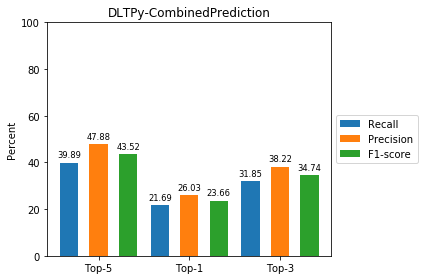

['Top-5', 'Top-1', 'Top-3'] [39.893956306809116, 21.687131239036837, 31.845000797321] [47.87580135872165, 26.026217586833795, 38.21643861831404] [43.52194146044449, 23.659374592267213, 34.74100813291002]


In [71]:
result_proc.plot_result(res, "DLTPy-CombinedPrediction")